In [1]:
import re
import pickle
import numpy as np
import pandas as pd
from gensim.models import Word2Vec
from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from Sastrawi.Stemmer.StemmerFactory import StemmerFactory
import nltk
from nltk.corpus import stopwords

# download stopwords and prepare the set
nltk.download("stopwords", quiet=True)
stops = set(stopwords.words("indonesian") + stopwords.words("english"))

# prepare stemmer
factory = StemmerFactory()
stemmer = nltk.stem.SnowballStemmer("english")

# load and filter hoax news
hoax = pd.read_csv(
    "../Dataset/hoax_news.csv", usecols=["Title", "Narasi", "category"]
).dropna(subset=["Title", "Narasi", "category"])
hoax = hoax[~hoax["category"].isin(["Benar", "Disinformasi"])]
hoax = hoax.rename(columns={"Title": "title", "Narasi": "body"})
hoax["label"] = "hoax"
# load and label real news
real = pd.read_csv(
    "../Dataset/detik_news.csv", usecols=["page", "title", "url", "content"]
).dropna(subset=["title", "content"])
real = real.rename(columns={"content": "body"})
real["label"] = "real"
real = real[["title", "body", "label"]]

# remove outliers from hoax based on text length
for field in ["title", "body"]:
    lengths = hoax[field].str.len()
    q1, q3 = lengths.quantile([0.25, 0.75])
    iqr = q3 - q1
    lower, upper = q1 - 1.5 * iqr, q3 + 1.5 * iqr
    hoax = hoax[(lengths >= lower) & (lengths <= upper)]
hoax = hoax.drop(columns=["category"])

# balance classes by downsampling
df = pd.concat([hoax, real], ignore_index=True)
min_count = df["label"].value_counts().min()
df = df.groupby("label", group_keys=False).apply(
    lambda g: g.sample(min_count, random_state=42)
)

# split into train, validation, and test sets (70:20:10)
X = df[["title", "body"]].astype(str)
y = df["label"]
X_temp, X_test, y_temp, y_test = train_test_split(
    X, y, test_size=0.1, stratify=y, random_state=42
)
val_frac = 0.2 / 0.9
X_train, X_val, y_train, y_val = train_test_split(
    X_temp, y_temp, test_size=val_frac, stratify=y_temp, random_state=42
)

# cleaning, tokenizing, and stemming function
def clean_tokenize(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    tokens = [t for t in text.split() if t not in stops and len(t) > 1]
    return [stemmer.stem(t) for t in tokens]

# prepare sentences for Word2Vec training
sentences = []
for _, row in X_train.iterrows():
    tokens = clean_tokenize(row['title']) + clean_tokenize(row['body'])
    sentences.append(tokens)

# train Word2Vec embeddings with vector_size=500
w2v_model = Word2Vec(
    sentences=sentences,
    vector_size=500,
    window=5,
    min_count=2,
    workers=4,
    seed=42
)

# function to compute average document vector
def document_vector(tokens):
    vecs = [w2v_model.wv[w] for w in tokens if w in w2v_model.wv]
    return np.mean(vecs, axis=0) if vecs else np.zeros(500)

# build feature vectors for each split
def build_features(df_split):
    features = []
    for _, row in df_split.iterrows():
        tokens = clean_tokenize(row['title']) + clean_tokenize(row['body'])
        features.append(document_vector(tokens))
    return np.vstack(features)

X_train_vec = build_features(X_train)
X_val_vec   = build_features(X_val)
X_test_vec  = build_features(X_test)

# encode labels to numeric form
encoder = LabelEncoder()
y_train_enc = encoder.fit_transform(y_train)
y_val_enc   = encoder.transform(y_val)
y_test_enc  = encoder.transform(y_test)

# train XGBoost classifier on embeddings
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42)
xgb_model.fit(X_train_vec, y_train_enc)

# evaluate on validation set
val_preds = xgb_model.predict(X_val_vec)
print("Validation accuracy:", accuracy_score(y_val_enc, val_preds))
print(classification_report(y_val_enc, val_preds, target_names=encoder.classes_))
print("Validation confusion matrix:")
print(confusion_matrix(y_val_enc, val_preds))

# evaluate on test set
test_preds = xgb_model.predict(X_test_vec)
print("Test accuracy:", accuracy_score(y_test_enc, test_preds))
print(classification_report(y_test_enc, test_preds, target_names=encoder.classes_))
print(confusion_matrix(y_test_enc, test_preds))

# save the pipeline for later use
with open("w2v_xgb_hoax.pkl", "wb") as f:
    pickle.dump({
        "model":         xgb_model,
        "w2v_model":     w2v_model,
        "label_encoder": encoder,
        "stopwords":     stops
    }, f)

print("Saved Word2Vec+XGBoost pipeline to w2v_xgb_hoax.pkl")


d:\Anaconda\envs\nlp\lib\site-packages\xgboost\core.py:158: UserWarning: [11:38:12] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-08cbc0333d8d4aae1-1\xgboost\xgboost-ci-windows\src\learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


Validation accuracy: 0.9515372589890568
              precision    recall  f1-score   support

        hoax       0.98      0.92      0.95       959
        real       0.92      0.98      0.95       960

    accuracy                           0.95      1919
   macro avg       0.95      0.95      0.95      1919
weighted avg       0.95      0.95      0.95      1919

Validation confusion matrix:
[[881  78]
 [ 15 945]]
Test accuracy: 0.9499478623566214
              precision    recall  f1-score   support

        hoax       0.97      0.93      0.95       480
        real       0.93      0.97      0.95       479

    accuracy                           0.95       959
   macro avg       0.95      0.95      0.95       959
weighted avg       0.95      0.95      0.95       959

[[447  33]
 [ 15 464]]
Saved Word2Vec+XGBoost pipeline to w2v_xgb_hoax.pkl


OOD Results for Word2Vec + XGBoost
Accuracy: 0.7333333333333333
              precision    recall  f1-score   support

        hoax      0.692     0.900     0.783        80
        real      0.826     0.543     0.655        70

    accuracy                          0.733       150
   macro avg      0.759     0.721     0.719       150
weighted avg      0.755     0.733     0.723       150



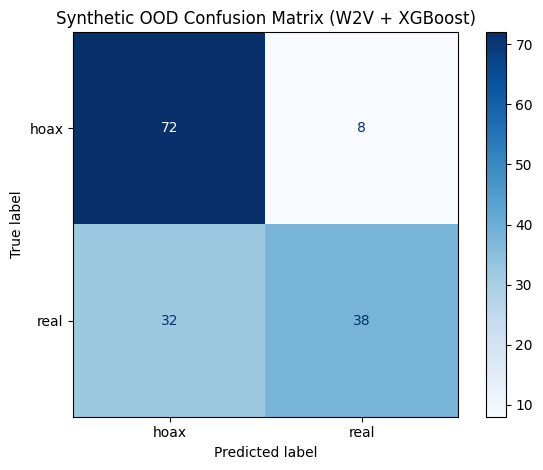

In [2]:
# test_w2v_xgb_synthetic.py

import re
import pickle
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, ConfusionMatrixDisplay
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
import nltk

# ensure stopwords are available
nltk.download("stopwords", quiet=True)
stops = set(stopwords.words("indonesian") + stopwords.words("english"))

# load the trained Word2Vec + XGBoost pipeline
with open("w2v_xgb_hoax.pkl", "rb") as f:
    data           = pickle.load(f)
    xgb_model      = data["model"]
    w2v_model      = data["w2v_model"]
    label_encoder  = data["label_encoder"]

# prepare stemmer
stemmer = SnowballStemmer("english")

def clean_tokenize(text):
    text = text.lower()
    text = re.sub(r"[^a-z\s]", " ", text)
    tokens = [t for t in text.split() if t not in stops and len(t) > 1]
    return [stemmer.stem(t) for t in tokens]

def document_vector(tokens):
    vecs = [w2v_model.wv[w] for w in tokens if w in w2v_model.wv]
    return np.mean(vecs, axis=0) if vecs else np.zeros(w2v_model.vector_size)

# load synthetic OOD set
titles, bodies, true_labels = [], [], []
with open("../Dataset/synthetic_news.txt", "r", encoding="utf-8") as f:
    for line in f:
        t, b, lab = line.strip().split("\t")
        titles.append(t)
        bodies.append(b)
        true_labels.append(lab)

# build feature matrix
features = []
for t, b in zip(titles, bodies):
    tokens = clean_tokenize(t) + clean_tokenize(b)
    features.append(document_vector(tokens))
X_syn = np.vstack(features)

# predict and decode labels
preds_num = xgb_model.predict(X_syn)
preds = label_encoder.inverse_transform(preds_num)

print("OOD Results for Word2Vec + XGBoost")
print("Accuracy:", accuracy_score(true_labels, preds))
print(classification_report(true_labels, preds, digits=3))

cm = confusion_matrix(true_labels, preds, labels=label_encoder.classes_)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_encoder.classes_)
disp.plot(cmap="Blues")
plt.title("Synthetic OOD Confusion Matrix (W2V + XGBoost)")
plt.tight_layout()
plt.show()
